In [1]:
#import libraries
from skimage.filters import threshold_sauvola
import matplotlib.pyplot as plt
from skimage import data, io
from skimage.color import rgb2gray, label2rgb
from skimage.morphology import skeletonize, remove_small_objects
from skimage.filters import gaussian
#from skan.pre import threshold
import numpy as np
#import numba
import os

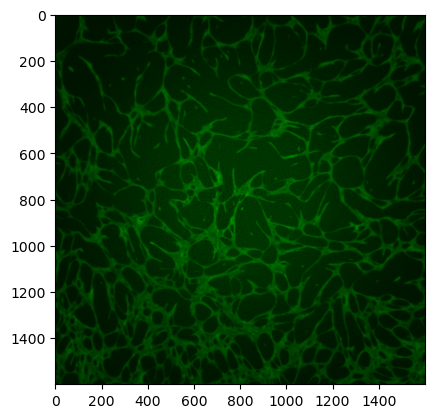

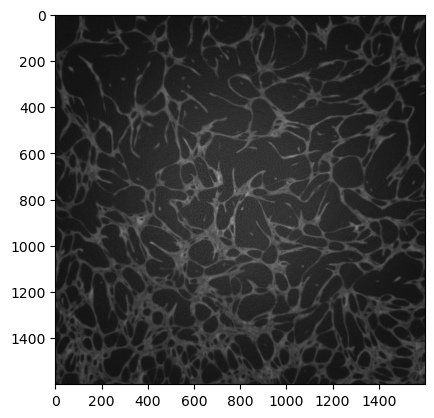

In [2]:
# os.chdir("//shares01.rdm.uq.edu.au/HKUG2023-A10939")
PATH = "\\\\shares01.rdm.uq.edu.au\\HKUG2023-A10939\\20230304_075556_96 wel plate_2D co culture_ HAEC P2_ASC52 P8_20230303_4X_TIME LAPSE\\WellC6\\F2\\MyExperiment_Wellc6_F2_000347.tif"
img = io.imread(PATH)
imgGrey = img[:,:,1]
plt.imshow(img)
plt.figure()
plt.imshow(imgGrey, cmap='gray')

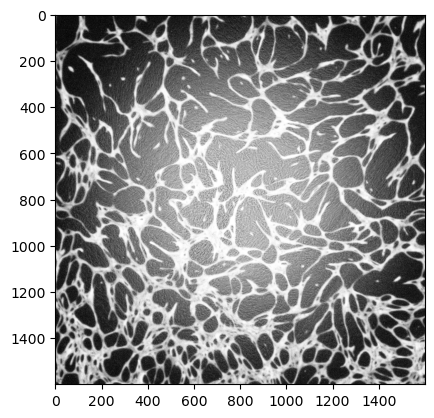

In [26]:
from skimage.exposure import equalize_hist
adapted_hist = equalize_hist(imgGrey)
plt.imshow(adapted_hist, cmap = 'gray')

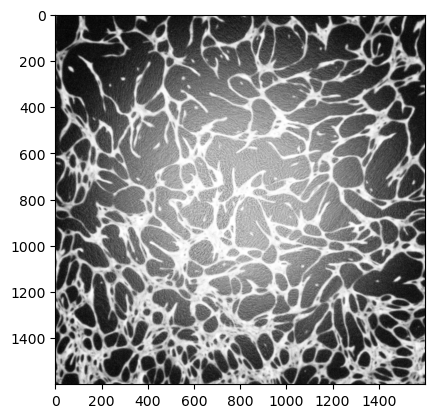

In [27]:
#Apply small gaussian blur
sigma = 1
blurred = gaussian(adapted_hist, sigma=(sigma, sigma), truncate=3.5, channel_axis=-1)
plt.figure()
plt.imshow(blurred, cmap = 'gray')

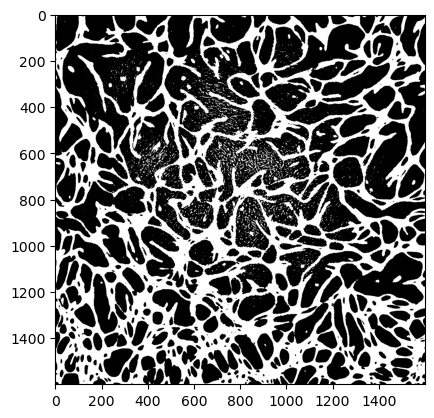

In [28]:
#Let's try some sauvola?
from skimage.filters import threshold_local
from skimage.morphology import disk
from skimage.filters.rank import otsu
import numpy as np

thresh = threshold_local(blurred , block_size = 301) 
bw = blurred > thresh

plt.imshow(bw, cmap = 'gray')

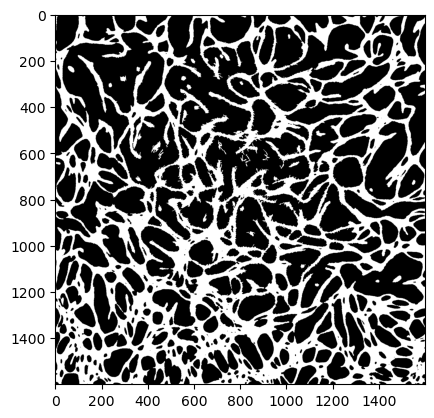

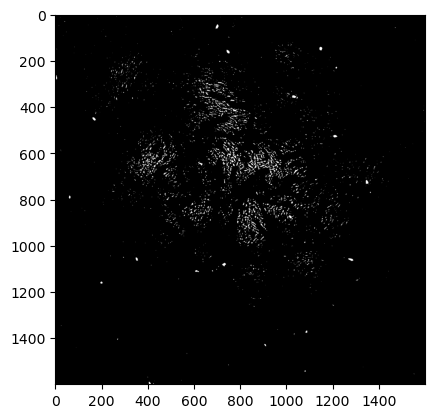

In [29]:
#Get rid of small areas
ensmallend = remove_small_objects(bw, min_size = 160, connectivity=8)
plt.imshow(ensmallend, cmap = 'gray')
diff = bw ^ ensmallend
plt.figure()
plt.imshow(diff, cmap='gray')

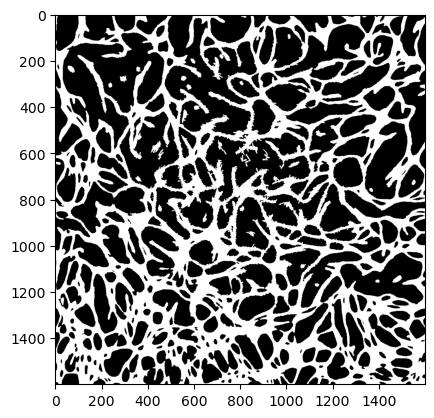

In [30]:
#Close Holes
from skimage.morphology import remove_small_holes, isotropic_dilation
#remove small holes
unholed = remove_small_holes(ensmallend, area_threshold = 100)
#morphological closing
dilated = isotropic_dilation(unholed, 1) #Dilation only used for skeleton

plt.imshow(dilated, cmap='gray')

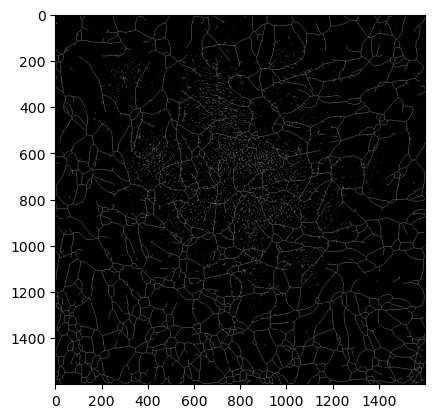

In [31]:
skel = skeletonize(bw).astype(np.uint16)
plt.imshow(skel, cmap='gray')

In [32]:
#import skimage
#skimage.io.imsave("C:\\Users\\harry\\Downloads\\skel.tiff", skel)

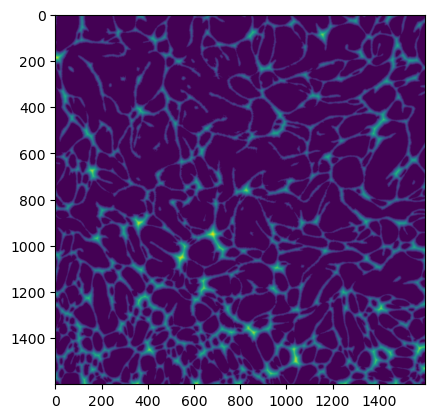

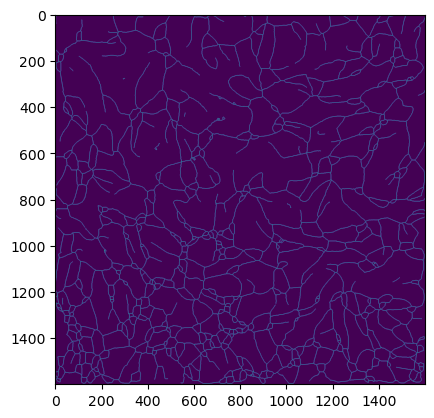

In [25]:
from dsepruning import skel_pruning_DSE
from scipy.ndimage import distance_transform_edt
skel_dist = distance_transform_edt(dilated,return_indices=False, return_distances=True)
plt.imshow(skel_dist)
pruned_skel = skel_pruning_DSE(skel,skel_dist,300).astype(np.uint16)
plt.figure()
plt.imshow(pruned_skel)

(1138, 2)


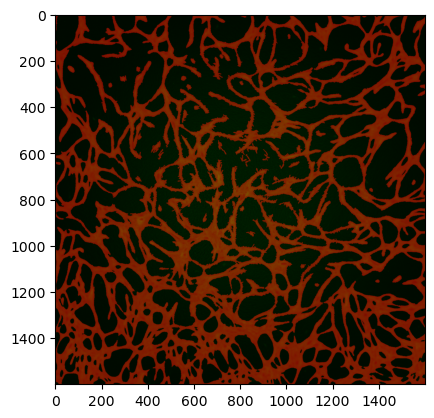

In [33]:
import sknw
from skan import draw
graph = sknw.build_sknw(pruned_skel)
nodes = graph.nodes()
ps = np.array([nodes[i]['o'] for i in nodes])
print(np.shape(ps))

fig, ax = plt.subplots()
masked = label2rgb(dilated,image=img, colors = ['red'], alpha=0.5, saturation = 1)
plt.imshow(masked)
#draw.overlay_skeleton_2d(masked, pruned_skel, dilate=2, axes=ax)
#plt.plot(ps[:,1], ps[:,0], 'b.')

981


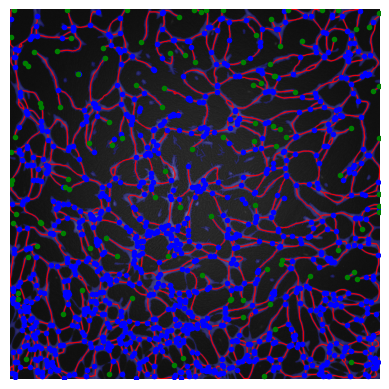

In [34]:
#try and use network x to differentiate branch pts from end pts
import networkx as nx
bp = []
ep = []
for node in nodes:
    if graph.degree[node] == 1:
        ep.append(node)
    elif graph.degree[node] > 2:
        bp.append(node)
branchPoints = np.array([nodes[i]['o'] for i in bp])
endPoints = np.array([nodes[i]['o'] for i in ep])

fig, ax = plt.subplots()
masked = label2rgb(dilated,image=img, colors = ['blue'], alpha=0.25)
draw.overlay_skeleton_2d(masked, pruned_skel, dilate=2, axes=ax)
plt.plot(branchPoints[:,1], branchPoints[:,0], 'b.')
plt.plot(endPoints[:,1], endPoints[:,0], 'g.')
print(len(branchPoints))

In [35]:
totalLen = 0
print(len(graph.edges()))
for (s,e) in graph.edges():
    ps = graph[s][e]['weight']
    totalLen += ps
print(totalLen)
print(totalLen/len(graph.edges()))
print(graph.edges())

1675
59104.148955435856
35.28605907787215
[(0, 23), (1, 24), (2, 12), (3, 37), (4, 18), (5, 19), (6, 16), (7, 36), (8, 25), (9, 9), (9, 29), (10, 20), (10, 10), (10, 44), (11, 21), (11, 11), (11, 14), (13, 13), (13, 32), (14, 70), (14, 39), (15, 31), (16, 16), (16, 22), (17, 17), (17, 33), (18, 19), (18, 29), (19, 48), (20, 22), (20, 47), (22, 48), (23, 23), (24, 52), (24, 50), (25, 27), (25, 30), (26, 41), (27, 38), (27, 45), (28, 43), (28, 30), (28, 54), (29, 42), (30, 64), (31, 34), (31, 97), (32, 36), (32, 52), (33, 57), (33, 55), (35, 35), (35, 40), (36, 40), (37, 38), (37, 49), (38, 45), (39, 73), (39, 63), (40, 46), (41, 42), (41, 43), (42, 77), (43, 69), (45, 93), (46, 59), (46, 88), (47, 51), (47, 53), (48, 79), (48, 51), (49, 67), (49, 93), (50, 56), (50, 85), (51, 94), (52, 56), (53, 72), (53, 71), (55, 57), (55, 59), (56, 75), (57, 61), (58, 83), (59, 60), (61, 61), (61, 74), (62, 94), (63, 73), (63, 65), (64, 64), (64, 115), (65, 66), (65, 98), (66, 66), (66, 67), (67, 78)

In [36]:
import skan.csr
degree = skan.csr.make_degree_image(pruned_skel) 
branches = degree > 2
ends = np.nonzero(degree == 1)
positions = np.nonzero(branches)


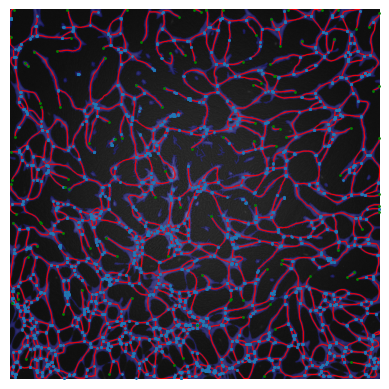

In [37]:
from skan import draw
fig, ax = plt.subplots()
masked = label2rgb(dilated,image=img, colors = ['blue'], alpha=0.25)
draw.overlay_skeleton_2d(masked, pruned_skel, dilate=2, axes=ax)
plt.scatter(positions[1], positions[0], s=1)
plt.scatter(ends[1], ends[0], s=1, color = ['green'])

In [38]:
#Set Cluster Distance
clusterDistance = 100
#np_pos = np.array(positions)
np_pos = np.vstack(positions).T
print(np_pos)
#Create a tree of points and query points until there are no points within the cluster distance
from scipy.spatial import KDTree
tree = KDTree(np_pos, compact_nodes=False, copy_data=True, balanced_tree=True)
points = list(tree.query_pairs(clusterDistance, p = 2)) #tuple -> immutable
#traversed = [False for i in range len(points)] #Boolean to denote if traversed
#Go through each of these cluster points, whittle down and remove them
# for point in points:
#     #Find all points close to given point
print(len(points))
    

[[   5 1187]
 [   5 1514]
 [   6 1187]
 ...
 [1594  740]
 [1594  741]
 [1595  545]]
83925


In [39]:
touched = [False for i in range(len(points))] #Stores if we've touched a given branch point
newPoints = []
for i in range(len(points)):
    point = points[i]
    closePoints = tree.query_ball_point(point, clusterDistance)
    if len(closePoints) > 0 and not touched[i]:
        #create list of tuples and adjust touched list
        closePointPositions = [points[j] for j in closePoints if not touched[j]]
        #Average Positions:
        x = sum(j[0] for j in closePointPositions)/len(closePoints)
        y = sum(j[1] for j in closePointPositions)/len(closePoints)
        #mark all points as touched
        for point in closePoints: touched[point] = True
        touched[i] = True
        #append averaged position to newPoints
        newPoints.append([x,y])
    elif not touched[i]:
        newPoints.append(point)
        touched[i] = True
print(np.shape(newPoints))

(83265, 2)


In [40]:
# Get number of cells
numPoints = len(positions[0])
# Size of image
imgSize = np.size(imgGrey)
# Area of Vessels
vesselArea = np.count_nonzero(dilated)
# Percentage Area
percentArea = vesselArea/imgSize * 100
print(imgSize, vesselArea, percentArea)
vesselLength = np.count_nonzero(pruned_skel)
print(vesselLength)
print(numPoints)
print(np.shape(ends))

2560000 1015926 39.684609375
57016
3226
(2, 116)
